<a href="https://colab.research.google.com/github/sarnavadatta/Finance-in-Python/blob/main/MonteCarlo_PortfolioOptimization_CVaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimization with Monte Carlo Simulation and CVaR

This notebook demonstrates a portfolio optimization process using historical stock data, Monte Carlo simulation for future price path generation, and Conditional Value at Risk (CVaR) optimization to determine optimal asset weights under specified constraints.

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import cvxpy as cp

In [ ]:
# Data Fetching ---
tickers = ['AAPL', 'TSLA', 'GOOG', 'META', 'MSFT', 'AMZN']
data = yf.download(tickers, start='2018-01-01', end='2025-07-07')['Close']

# Calculate Log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Parameter Estimation
mu = log_returns.mean().values
cov = log_returns.cov().values
L = np.linalg.cholesky(cov)

# Current prices
S0 = data.iloc[-1].values

/tmp/ipython-input-2-3534635282.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2018-01-01', end='2025-07-07')['Close']
[*********************100%***********************]  6 of 6 completed


The price at time $t$, $S_t$, is simulated using the following formula, based on geometric Brownian motion:

$$
S_t = S_{t-\Delta t} \exp\left( (\mu - \frac{1}{2}\Sigma) \Delta t + L Z_t \sqrt{\Delta t} \right)
$$

Where:
*   $S_t$: Price at time $t$.
*   $S_{t-\Delta t}$: Price at the previous time step $t-\Delta t$.
*   $\mu$: Vector of expected log returns.
*   $\Sigma$: Covariance matrix of log returns.
*   $\Delta t$: Time step size.
*   $L$: Cholesky decomposition of the covariance matrix $\Sigma$, such that $\Sigma = LL^T$.
*   $Z_t$: Vector of independent standard normal random variables at time $t$.
*   $LZ_t$: Vector of correlated normal random variables.

In [ ]:
# --- Monte Carlo Simulation ---
T = 1
N = 252
M = 10000
dt = T / N
n_assets = len(tickers)
np.random.seed(42)

simulated_paths = np.zeros((N, M, n_assets))
simulated_paths[0] = S0

for t in range(1, N):
    Z = np.random.standard_normal((M, n_assets))
    correlated_Z = Z @ L.T
    drift = (mu - 0.5 * np.diag(cov)) * dt
    diffusion = correlated_Z * np.sqrt(dt)
    log_returns_t = drift + diffusion
    simulated_paths[t] = simulated_paths[t-1] * np.exp(log_returns_t)

# --- Final Prices (1 Year) ---
final_prices = simulated_paths[-1]  # shape: (M, n_assets)


The optimization problem is formulated to minimize the Conditional Value at Risk (CVaR) of the portfolio, which is a more robust risk measure than Value at Risk (VaR). The objective function and constraints are as follows:

**Minimize:**

$$
\text{CVaR}_{\alpha} = \text{VaR}_{\alpha} + \frac{1}{\alpha M} \sum_{m=1}^{M} \max(0, \text{Initial Value} - \text{Portfolio Value}_m - \text{VaR}_{\alpha})
$$

Where:
*   $\text{CVaR}_{\alpha}$: Conditional Value at Risk at the $\alpha$ confidence level.
*   $\text{VaR}_{\alpha}$: Value at Risk at the $\alpha$ confidence level.
*   $\alpha$: The confidence level (e.g., 0.05 for 95% VaR/CVaR).
*   $M$: The number of Monte Carlo simulations.
*   $\text{Initial Value}$: The initial value of the portfolio (normalized to 1.0 in this case).
*   $\text{Portfolio Value}_m$: The simulated portfolio value in the $m$-th simulation.

In the provided code, a linear approximation of the CVaR objective is used, which is equivalent to minimizing $\text{VaR} + \frac{1}{\alpha M} \sum_{m=1}^{M} z_m$, subject to $z_m \ge 0$ and $z_m \ge \text{Initial Value} - \text{Portfolio Value}_m - \text{VaR}$ for each simulation $m$.

**Subject to the following constraints:**

1.  **Sum of Weights Constraint:** The sum of the portfolio weights must equal 1. This ensures that the entire portfolio value is allocated among the selected assets.
    $$
    \sum_{i=1}^{n} w_i = 1
    $$
    Where $w_i$ is the weight of asset $i$ and $n$ is the number of assets.

2.  **Minimum Weight Constraint:** Each asset must have a minimum allocation of 5% (0.05). This constraint prevents concentrating the entire portfolio into a single asset and promotes diversification.
    $$
    w_i \ge 0.05 \quad \text{for all } i=1, \dots, n
    $$

3.  **Maximum Weight Constraint:** Each asset can have a maximum allocation of 30% (0.3). This constraint also helps in diversification and limits the exposure to any single asset.
    $$
    w_i \le 0.3 \quad \text{for all } i=1, \dots, n
    $$

4.  **Auxiliary Variable Constraint (for CVaR linear approximation):** These constraints are part of the linear approximation of the CVaR objective. They ensure that the auxiliary variables $z_m$ capture the "losses exceeding VaR" for each simulation $m$.

  $$
    z_m \ge 0 \quad \text{for all } m=1, \dots, M
  $$

  $$
  z_m \ge \text{Initial Value} - \text{Portfolio Value}_m - \text{VaR}_{\alpha} \quad \text{for all } m=1, \dots, M
  $$

The optimization problem finds the optimal portfolio weights ($w_i$) that minimize the CVaR while satisfying these allocation constraints.

In [ ]:
# --- Step 4: Optimize Portfolio Under Constraints ---
alpha = 0.05
initial_portfolio_value = 1.0  # normalized

# CVaR Optimization (linear approx of VaR)
w = cp.Variable(n_assets)
portfolio_values = final_prices @ w
VaR = cp.Variable()
z = cp.Variable(M)

objective = VaR + (1 / (alpha * M)) * cp.sum(z)
constraints = [
    cp.sum(w) == 1,
    w >= 0.05,
    w <= 0.3,
    z >= 0,
    z >= initial_portfolio_value - portfolio_values - VaR
]

problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# --- Step 5: Output Optimal Weights and VaR ---
optimal_weights = w.value
portfolio_vals = final_prices @ optimal_weights
VaR_optimized = initial_portfolio_value - np.percentile(portfolio_vals, 5)

print("Optimal Portfolio Weights with Constraints:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]:.4f}")

print(f"\n Constrained Portfolio VaR (95%, 1 year): ${VaR_optimized:.4f}")

Optimal Portfolio Weights with Constraints:
AAPL: 0.0500
TSLA: 0.0500
GOOG: 0.0500
META: 0.3000
MSFT: 0.3000
AMZN: 0.2500

 Constrained Portfolio VaR (95%, 1 year): $-458.1026


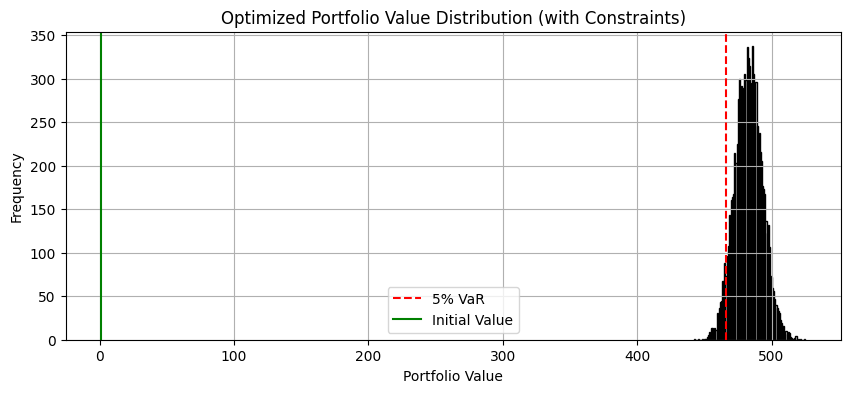

In [ ]:
# Plot final portfolio distribution
plt.figure(figsize=(10, 4))
plt.hist(portfolio_vals, bins=100, color='lightgray', edgecolor='black')
plt.axvline(np.percentile(portfolio_vals, 5), color='red', linestyle='--', label='5% VaR')
plt.axvline(initial_portfolio_value, color='green', linestyle='-', label='Initial Value')
plt.title("Optimized Portfolio Value Distribution (with Constraints)")
plt.xlabel("Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()